# Bird Demo


This notebook shows how to build a simple bird classifier using MobileNetV2 TF2.x image classification model

By completing this notebook, you will learn:
* How to write a Python script for your app that takes in camera streams, performs inference, and outputs results
* How to use a Tensorflow Image Classification model with Panorama
* How to bundle additional Python files and libraries with your container
* How to test your code using the Panorama emulator, which saves you build and deploy time
* How to programmatically package and deploy applications using the Panorama CLI

--- 

1. [Prerequisites](#Prerequisites)
1. [Set up](#Set-up)
1. [Import model](#Import-model)
1. [Write and test app code](#Write-and-test-app-code)
1. [Package app](#Package-app)
1. [Deploy app to device](#Deploy-app-to-device)

# Prerequisites

1. In a terminal session on this Jupyter notebook server, run `aws configure`. This allows this notebook server to access Panorama resources on your behalf.

In [1]:
# Run this only once
!pip3 install scipy

# Set Up
Import libraries for use with this notebook environment, you do not need these libraries when you write your application code. Run these 3 cells every time you update your app code and restart your kernel.

In [2]:
import sys
import os
import time
import json

import boto3
import sagemaker

import matplotlib.pyplot as plt
from IPython.core.magic import register_cell_magic

sys.path.insert( 0, os.path.abspath( "../common/test_utility" ) )
import panorama_test_utility

# instantiate boto3 clients
s3_client = boto3.client('s3')
panorama_client = boto3.client('panorama')

# configure matplotlib
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,20)

# register custom magic command
@register_cell_magic
def save_cell(line, cell):
    'Save python code block to a file'
    with open(line, 'wt') as fd:
        fd.write(cell)

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Copy the test video in the correct folder directory for the test utility

## Notebook parameters

Global constants that help the notebook create Panorama resources on your behalf.

In [3]:
## Device Related Globals
DEVICE_ID = 'test-device-id' # Device ID, should look like: device-oc66nax4cgzwhyuaeyifrqowue
assert DEVICE_ID != '', "PLEASE ENTER  YOUR DEVICE ID"

# Bucket Related Globals
S3_BUCKET = 'sagemaker-us-west-2-987720697751' # Enter your S3 bucket info here
assert S3_BUCKET != '', "PLEASE ENTER A BUCKET NAME"

# AWS region
AWS_REGION = 'us-west-2' # Enter your desired AWS region

# Name of your model
ML_MODEL_FNAME = 'mobilenet_v2_bird'

In [4]:
# application name
app_name = 'bird_demo_app'

## package names and node names
code_package_name = 'BIRD_DEMO_CODE'
model_package_name = 'BIRD_DEMO_TF_MODEL'
camera_node_name = 'RTSP_STREAM'

# model node name, raw model path (without platform dependent suffics), and input data shape
model_node_name = "model_node"
model_file_basename = "./models/" + ML_MODEL_FNAME
model_data_shape = '{"input_1":[1,224,224,3]}'

# video filename to simulate camera stream
videoname = 'bird.mp4'

# AWS account ID
account_id = boto3.client("sts").get_caller_identity()["Account"]

## Set up application

Every application uses the creator's AWS Account ID as the prefix to uniquely identifies the application resources. Running `panorama-cli import-application` replaces the generic account Id with your account Id.

In [5]:
!cd ./bird_demo_app && panorama-cli import-application

Sucessfully imported application


# Import model

We need to compile and import the model twice. Once for testing with this notebook server and once for deploying to the Panorama device.

While working with the Panorama sample code, we provide pretrained models for you to use. Locally, models are stored in `panorama_sdk/models`. This step downloads the model artifacts from our Amazon S3 bucket to the local folder. If you want to use your own models, put your tar.gz file into the `panorama_sdk/models folder`.

### Prepare model for testing with notebook server

In [6]:
# put the s3 link of your model artifacts here
s3_model = 's3://sagemaker-us-west-2-987720697751/8lpv6zw4nz8p-BirdEnd-bQbqFgG3A7-001-3f575f7f/output/model.tar.gz'
local_path = f'./models/{ML_MODEL_FNAME}.tar.gz'
!aws s3 cp $s3_model $local_path

download: s3://sagemaker-us-west-2-987720697751/8lpv6zw4nz8p-BirdEnd-bQbqFgG3A7-001-3f575f7f/output/model.tar.gz to models/mobilenet_v2_bird.tar.gz


In [7]:
# Compile the model to run with test-utility.
# This step takes 30 mins ~ 40 mins.
%run ../common/test_utility/panorama_test_utility_compile.py \
\
--s3-model-location s3://{S3_BUCKET}/{app_name}/ \
\
--model-node-name model_node \
--model-file-basename ./models/{ML_MODEL_FNAME} \
--model-data-shape '{model_data_shape}' \
--model-framework TENSORFLOW

Checking [model_node]
Compiled model file [./models/model_node/mobilenet_v2_bird-LINUX_ARM64.tar.gz] doesn't exist. Need compilation.
Uploading [mobilenet_v2_bird.tar.gz] to [s3://sagemaker-us-west-2-987720697751/bird_demo_app/model_node] ...
Compiling [mobilenet_v2_bird.tar.gz] ...
Created compilation job [Comp-Job20220320051504PM]
Compilation job status : STARTING ...
Compilation job status : INPROGRESS ........
Compilation job status : COMPLETED 
Extracting compiled model in [./models/model_node/mobilenet_v2_bird-LINUX_ARM64] ...
Done.


### Prepare model for deploying to Panorama device


In [ ]:
model_asset_name = 'model_asset'
model_package_path = f'packages/{account_id}-{model_package_name}-1.0'
model_descriptor_path = f'packages/{account_id}-{model_package_name}-1.0/descriptor.json'

In [ ]:
!cd ./bird_demo_app && panorama-cli add-raw-model \
    --model-asset-name {model_asset_name} \
    --model-s3-uri s3://{S3_BUCKET}/{app_name}/model_node/{ML_MODEL_FNAME}.tar.gz \
    --descriptor-path {model_descriptor_path}  \
    --packages-path {model_package_path}

download: s3://sagemaker-us-west-2-987720697751/bird_demo_app/model_node/mobilenet_v2_bird.tar.gz to assets/model_asset.tar.gz
Updating an existing asset with the same name
{
    "name": "model_asset",
    "implementations": [
        {
            "type": "model",
            "assetUri": "ae6c7df9e9aaff6e5001f88c82f5cc938ab84b7a01a38247083f2542f30e65cf.tar.gz",
            "descriptorUri": "1d13ccfae4b1b8cde03bfa404c7115538d511320db773a24fed30a2b9d78f355.json"
        }
    ]
}
Successfully downloaded the model to /home/ubuntu/aws-panorama-samples/samples/bird_demo/bird_demo_app/assets/ae6c7df9e9aaff6e5001f88c82f5cc938ab84b7a01a38247083f2542f30e65cf.tar.gz


# Write and test app code

Every app has an entry point script, written in Python that pulls the frames from camera streams, performs inference, and send the results to the desired location. This file can be found in `your_app/packages/code_node/src/main.py`. Below, you will iterate on the code from within the notebook environment. The entry point file will be updated everytime you run the next notebook cell thanks to the `%%run_and_save app.py`. This is a utility function to update the contents of the entry point script. 

The next cell will loop through the test video until you select Stop on your Jupyter notebook cell. 

### Iterating on Code Changes

To iterate on the code:
1. Make changes in the next cell. 
2. Stop the Notebook and Reset the Kernel.
3. Run the 3 Setup cells again before re-running the code cell below.

**CHANGE VIDEO** : For you to change video, please place the video in samples/panorama_sdk/videos and update the global variables with the video and extension name (video.avi for example)

Run only the Set up and Notebook Parameters cells before running this for reiteration

In [ ]:
%%save_cell ./{app_name}/packages/{account_id}-{code_package_name}-1.0/src/app.py

import json
import logging
import time
from logging.handlers import RotatingFileHandler

import boto3
from botocore.exceptions import ClientError
import cv2
import numpy as np
import panoramasdk
import datetime

class Application(panoramasdk.node):
    def __init__(self):
        """Initializes the application's attributes with parameters from the interface, and default values."""
        self.MODEL_NODE = "model_node"
        self.MODEL_DIM = 224
        self.frame_num = 0
        self.tracked_objects = []
        self.tracked_objects_start_time = dict()
        self.tracked_objects_duration = dict()
    
        self.classes = {
            0: "Bobolink", 
            1: "Cardinal", 
            2: "Purple_Finch",
            3: "Northern_Flicker",
            4:"American_Goldfinch",
            5:"Ruby_throated_Hummingbird",
            6:"Blue_Jay",
            7:"Mallard"   
        }

    def process_streams(self):
        """Processes one frame of video from one or more video streams."""
        self.frame_num += 1
        logger.debug(self.frame_num)

        # Loop through attached video streams
        streams = self.inputs.video_in.get()
        for stream in streams:
            self.process_media(stream)

        self.outputs.video_out.put(streams)

    def process_media(self, stream):
        """Runs inference on a frame of video."""
        image_data = preprocess(stream.image, self.MODEL_DIM)
        logger.debug(image_data.shape)

        # Run inference
        inference_results = self.call({"input_1":image_data}, self.MODEL_NODE)

        # Process results (object deteciton)
        self.process_results(inference_results, stream)

    def process_results(self, inference_results, stream):
        """Processes output tensors from a computer vision model and annotates a video frame."""
        if inference_results is None:
            logger.warning("Inference results are None.")
            return
        
        logger.debug('Inference results: {}'.format(inference_results))
        count = 0
        for det in inference_results:
            if count == 0:
                first_output = det
            count += 1
            
        # first_output = inference_results[0]
        logger.debug('Output one type: {}'.format(type(first_output)))
        probabilities = first_output[0]
        # 1000 values for 1000 classes
        logger.debug('Result one shape: {}'.format(probabilities.shape))
        top_result = probabilities.argmax()
        
        self.detected_class = self.classes[top_result]
        self.detected_frame = self.frame_num
        # persist for up to 5 seconds
        # if self.frame_num - self.detected_frame < 75:
        label = '{} ({}%)'.format(self.detected_class, int(probabilities[top_result]*100))
        stream.add_label(label, 0.1, 0.1)

def preprocess(img, size):
    """Resizes and normalizes a frame of video."""
    resized = cv2.resize(img, (size, size))
    x1 = np.asarray(resized)
    x1 = np.expand_dims(x1, 0)
    return x1

def get_logger(name=__name__,level=logging.INFO):
    logger = logging.getLogger(name)
    logger.setLevel(level)
    handler = RotatingFileHandler("/opt/aws/panorama/logs/app.log", maxBytes=100000000, backupCount=2)
    formatter = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s',
                                    datefmt='%Y-%m-%d %H:%M:%S')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

def main():
    try:
        logger.info("INITIALIZING APPLICATION")
        app = Application()
        logger.info("PROCESSING STREAMS")
        while True:
            app.process_streams()
    except Exception as e:
        logger.warning(e)

logger = get_logger(level=logging.INFO)
main()

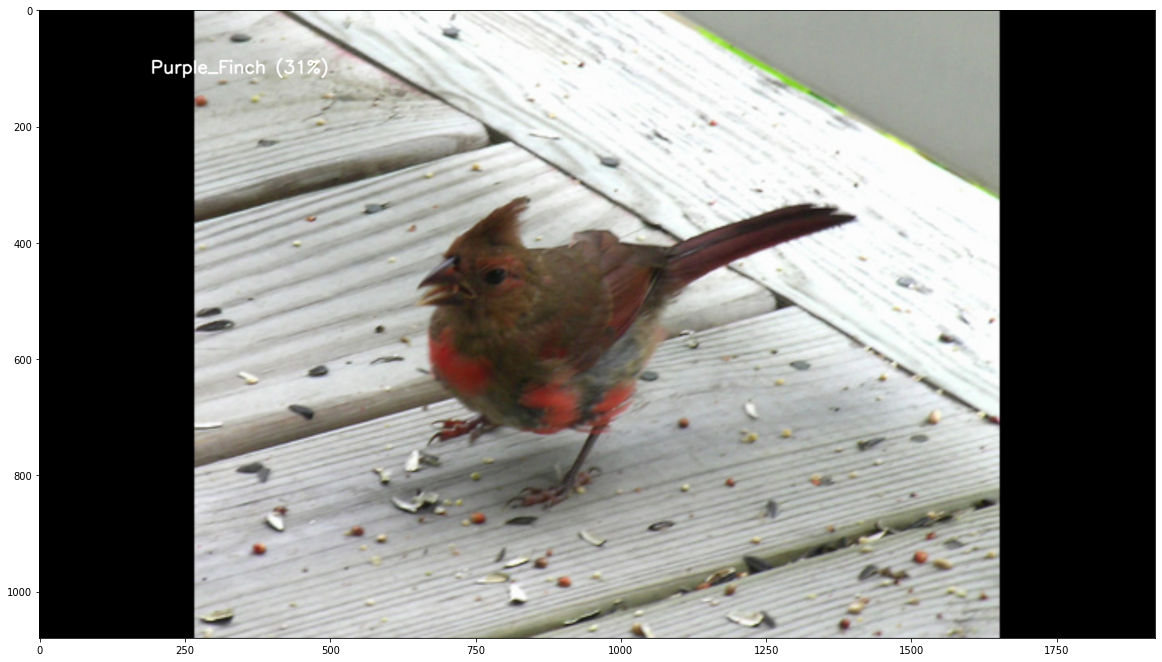

<Figure size 1440x1440 with 0 Axes>

In [12]:
# Run the application with test-utility.
#
# As '--output-pyplot' option is specified, this command simulates HDMI output with pyplot rendering in the output cell.
# In order to see console output (stdout/stderr) from the application, please remove the --output-pyplot option.
#
%run ../common/test_utility/panorama_test_utility_run.py \
\
--app-name {app_name} \
--code-package-name {code_package_name} \
--model-package-name {model_package_name} \
--camera-node-name {camera_node_name} \
--model-node-name {model_node_name} \
--model-file-basename {model_file_basename} \
--video-file {videoname} \
--py-file ./{app_name}/packages/{account_id}-{code_package_name}-1.0/src/app.py \
--output-pyplot

# Package app

Updates the app to be deployed with the recent code

In [14]:
py_file_name = 'app.py'
panorama_test_utility.update_package_descriptor( app_name, account_id, code_package_name, py_file_name )

### Build app with container

In [15]:
container_asset_name = 'code_asset'

In [18]:
%%capture captured_output

# Building container image.This process takes time (5min ~ 10min)
# FIXME : without %%capture, browser tab crashes because of too much output from the command.

!cd ./bird_demo_app && panorama-cli build \
    --container-asset-name {container_asset_name} \
    --package-path packages/{account_id}-{code_package_name}-1.0

In [19]:
stdout_lines = captured_output.stdout.splitlines()
stderr_lines = captured_output.stderr.splitlines()
print("     :")
print("     :")
for line in stdout_lines[-30:] + stderr_lines[-30:]:
    print(line)

     :
     :
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Removing intermediate container 1f683968e9ca
 ---> ed755ebedb3b
Successfully built ed755ebedb3b
Successfully tagged code_asset:latest
docker export --output=code_asset.tar $(docker create code_asset:latest)
gzip -9 code_asset.tar
{
    "name": "code_asset",
    "implementations": [
        {
            "type": "container",
            "assetUri": "4f1fdec28a45df7b4cee58e9ec1e4c9440fd3d85cf36c15a3183920b9692cd32.tar.gz",
            "descriptorUri": "577ccf8b6cff24dc1f90cc2af22644ee9d0c81b5a22e771287bf3630e1b7b8fb.json"
        }
    ]
}
Container asset for the package has been succesfully built at  /home/ubuntu/aws-panorama-samples/samples/bird_demo/bird_demo_app/

### Upload application to Panorama for deploying to devices

### Update camera streams

In the AWS Panorama console, you can select the camera streams, but programmatically, you need to define the camera stream info for the cameras you are using with the app.

Open the ```package.json``` in ```packages/<account_number>-RTSP_STREAM-1.0``` and update the camera username, password and URL. After you have updated your camera credentials, run package-application. You can override this camera stream when you deploy the app.

In [20]:
# This step takes some time, depending on your network environment.
!cd ./bird_demo_app && panorama-cli package-application

Uploading package BIRD_DEMO_TF_MODEL
Package Version 1.0 is not yet registered, preparing upload
upload: assets/ae6c7df9e9aaff6e5001f88c82f5cc938ab84b7a01a38247083f2542f30e65cf.tar.gz to s3://arn:aws:s3:us-west-2:454554846382:accesspoint/panorama-987720697751-ds75ikgh2brbohilyqcxjuvm3i/987720697751/nodePackages/BIRD_DEMO_TF_MODEL/binaries/ae6c7df9e9aaff6e5001f88c82f5cc938ab84b7a01a38247083f2542f30e65cf.tar.gz
upload: assets/1d13ccfae4b1b8cde03bfa404c7115538d511320db773a24fed30a2b9d78f355.json to s3://arn:aws:s3:us-west-2:454554846382:accesspoint/panorama-987720697751-ds75ikgh2brbohilyqcxjuvm3i/987720697751/nodePackages/BIRD_DEMO_TF_MODEL/binaries/1d13ccfae4b1b8cde03bfa404c7115538d511320db773a24fed30a2b9d78f355.json
{
    "ETag": "\"9640671484eda5cfad5e8376da9814cf\"",
    "ServerSideEncryption": "AES256",
    "VersionId": "UgNzQLNLkm1UW4OIIWDsWs8hqI9WmXoC"
}
Called register package version for BIRD_DEMO_TF_MODEL with patch version e4241d3c8bcd6d353960e22a43af02adf89333355b648a239041311

### Ready for deploying to a device

Congrats! Your app is now ready to deploy to a device. Next, you can continue in this notebook to deploy the app programmatically or you can go to the Panorama console and deploying using a GUI. The GUI makes it easier to select camera streams and select the devices you want to deploy to. Programmatic deployment is faster to complete and easier to automate.

# Deploy app to device

Let's make sure the device we are deploying to is available.

In [ ]:
response = panorama_client.describe_device(
    DeviceId= DEVICE_ID
)

print('You are deploying to Device: {}'.format(response['Name']))

#### Deploy Application

In [ ]:
response = panorama_test_utility.deploy_app(DEVICE_ID, app_name, role=None)

application_instance_id = response['ApplicationInstanceId']

response

# Clean up

In [ ]:
panorama_test_utility.remove_application( DEVICE_ID, application_instance_id )